# Unifying Distributed Training Strategies Under one Scheme

This notebook is a companion to [this paper](parallelsim.html.pdf). It shows how
various forms of parallelism can be rewritted as variants of a single scheduling
algorithm by specifying just two functions: a function that maps work to a
compute worker, and a function that maps weights to a storage worker. By just
changing these functions, we recover Pipeline Parallel, Data Parallle, Fully
Sharded Data Parallel, Looped Pipeline Parallel, their variants, and some new
forms of parallelism.


To run the notebook, execute

```
bazel run //cruise/mlp/robotorch2/lightning/strategies/notebooks:parallelsim_notebook
```

The pipeline diagrams below illustrate various training schedules. In
these diagrams, the columns are time indices, and each row corresponds to a
worker. The cells in the diagram describe the activity of the worker during the
corresponing time.  The color of each cell indicates the id of the batch being
processed. The cell value indicates whether the work is for the forward or
backward pass, and the pipeline stage being processed.

In [46]:
from importlib import reload
from IPython import display

import parallelsim

reload(parallelsim)

from parallelsim import Work, ComputeAndWeightWorkers


# Distributed Data Parallelism schemes

In these schemes, there is a 1:1 correspondence between workers and batches. Each worker processes every stage of the batch assigned to it in sequence.

In [94]:
num_workers = 6
num_stages = 6
num_batches = 6


def DistributedDataParallel(w: Work):
    return ComputeAndWeightWorkers(w.batch, w.batch)


assert num_batches == num_workers


parallelsim.simulate(num_workers, num_stages, num_batches, DistributedDataParallel)

SimulationStats(num_workers=6, num_stages=6, num_batches=6, schedule=<function DistributedDataParallel at 0x1388def70>)

In [95]:
def FullyShardedDistributedDataParallel(w: Work):
    return ComputeAndWeightWorkers(w.batch, w.stage % num_workers)


assert num_batches == num_workers


parallelsim.simulate(
    num_workers, num_stages, num_batches, FullyShardedDistributedDataParallel
)

SimulationStats(num_workers=6, num_stages=6, num_batches=6, schedule=<function FullyShardedDistributedDataParallel at 0x1388deee0>)

# Pipeline Parallelism Schemes

In these schemes, there is a 1:1 correspondence between workers and stages. Each worker processes just one stage of every batch.

,Aggegrate Metrics
Worker throughput (jobs / time / worker),0.446771
Max activation storage for a worker,128.000000
Mean activation storage for workers,128.000000


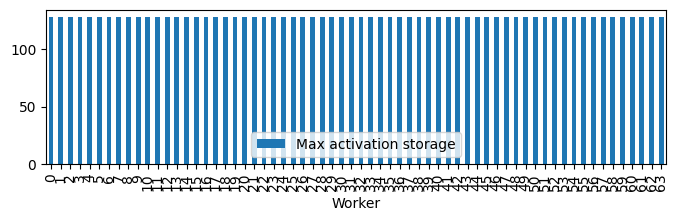

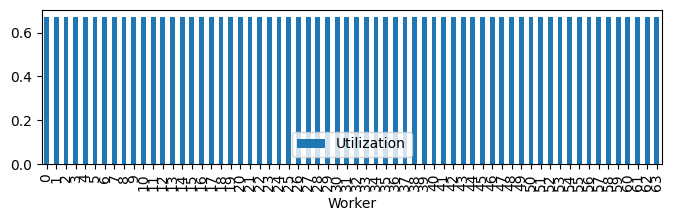

In [96]:
num_stages = 64
num_workers = 64
num_batches = 128


def GPipe(w: Work):
    return ComputeAndWeightWorkers(w.stage, w.stage)


assert num_stages == num_workers

parallelsim.simulate(
    num_workers,
    num_stages,
    num_batches,
    GPipe,
    parallelsim.OldestStageFirst(num_stages, num_batches),
)

,Aggegrate Metrics
Worker throughput (jobs / time / worker),0.446771
Max activation storage for a worker,128.000000
Mean activation storage for workers,85.000000


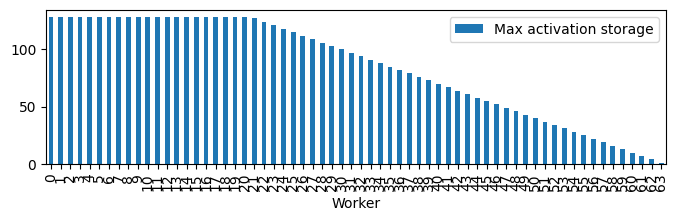

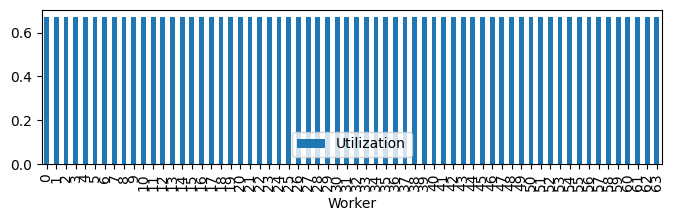

In [97]:
parallelsim.simulate(num_workers, num_stages, num_batches, GPipe)

,Aggegrate Metrics
Worker throughput (jobs / time / worker),0.408946
Max activation storage for a worker,116.000000
Mean activation storage for workers,87.750000


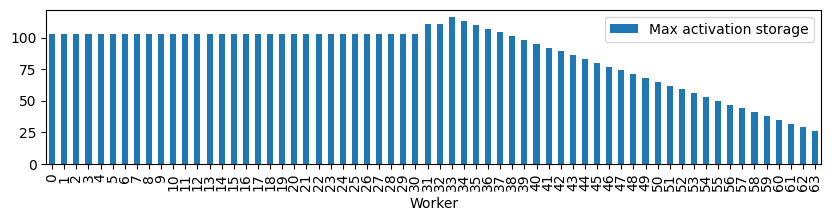

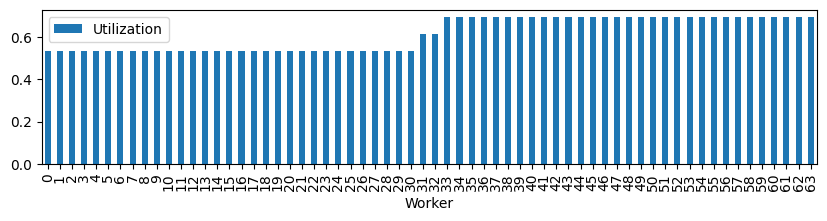

In [ ]:
def CuckooParallelism(work: Work) -> ComputeAndWeightWorkers:
    if (
        work.direction == parallelsim.Direction.BACKWARD
        and work.stage <= num_stages // 2
        and work.batch < num_batches // 5
    ):
        # This work will require the compute worker to retain the
        # input activations for at least num_stages time steps.
        return ComputeAndWeightWorkers(num_workers - work.stage - 1, work.stage)
    return ComputeAndWeightWorkers(work.stage, work.stage)


parallelsim.simulate(num_workers, num_stages, num_batches, CuckooParallelism)

# Looped Pipeline Parallelism

These schemes generalize Pipeline Parallism by allowing each worker to process
more than one stage of the pipelne. Each batch is assigned to a group of workers
based on its batch id, and if that group has fewer workers than there are
stages, each worker computes several stages of the pipeline for that batch.

In [44]:
group_size = 3


def LoopedPipelineParallelism(w: Work):
    def h(x, y):
        return (group_size * y % num_workers) + (x % group_size)

    worker = h(w.stage, w.batch)
    return ComputeAndWeightWorkers(worker, worker)


parallelsim.simulate(num_workers, num_stages, num_batches, LoopedPipelineParallelism)

SimulationStats(num_workers=6, num_stages=6, num_batches=12, schedule=<function LoopedPipelineParallelism at 0x10e6001f0>)

In [45]:
group_size = 3


def FullyShardedLoopedPipelineParallelism(w: Work):
    def h(x, y):
        return (group_size * y % num_workers) + (x % group_size)

    return ComputeAndWeightWorkers(h(w.stage, w.batch), h(w.stage, w.stage))


parallelsim.simulate(
    num_workers, num_stages, num_batches, FullyShardedLoopedPipelineParallelism
)

SimulationStats(num_workers=6, num_stages=6, num_batches=12, schedule=<function FullyShardedLoopedPipelineParallelism at 0x10e5ed700>)